# Earthquake Forecasting and Clustering Analysis in the Pacific Northwest

This notebook presents a comprehensive analysis of earthquake patterns and prediction models in the Pacific Northwest. It includes:

-  Machine learning models to classify the likelihood of earthquake occurrence and forecast magnitude  
-  Feature engineering with spatiotemporal and seasonal factors  
-  Performance evaluation using classification metrics and regression scores  
-  KMeans clustering to explore spatial groupings based on actual earthquake features

The goal is to identify seismic risk zones to support hazard mitigation and planning efforts.


In [1]:
# Import dependencies 
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE


##  Data Cleaning and Feature Engineering

In [2]:
# STEP 1: Load and preprocess dataset
df = pd.read_csv('Resources/pnw_final.csv')
df['time'] = pd.to_datetime(df['time'], utc=True, errors='coerce')
df = df.dropna(subset=['latitude', 'longitude', 'mag'])

In [3]:
# STEP 2: Bin spatially and temporally
grid_size = 0.5
lat_bounds = (39.5, 49.5)
lon_bounds = (-125.0, -116.0)
df = df[
    (df['latitude'] >= lat_bounds[0]) & (df['latitude'] <= lat_bounds[1]) &
    (df['longitude'] >= lon_bounds[0]) & (df['longitude'] <= lon_bounds[1])
].copy()

df['time_bin'] = df['time'].dt.to_period('M').astype(str)
df['prev_time_bin'] = (df['time'].dt.to_period('M') - 1).astype(str)
df['lat_bin'] = (df['latitude'] // grid_size) * grid_size
df['lon_bin'] = (df['longitude'] // grid_size) * grid_size

C:\Users\sofon\AppData\Local\Temp\ipykernel_31684\4260447439.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['time_bin'] = df['time'].dt.to_period('M').astype(str)
C:\Users\sofon\AppData\Local\Temp\ipykernel_31684\4260447439.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['prev_time_bin'] = (df['time'].dt.to_period('M') - 1).astype(str)


In [4]:
# STEP 3: Aggregate quake data with correct labeling
grouped = df.groupby(['time_bin', 'lat_bin', 'lon_bin']).agg(
    max_mag_now=('mag', 'max'),
    count_now=('mag', 'count')
).reset_index()
grouped['quake_occurred'] = 1

In [5]:
# STEP 4: Create full grid
monthly = pd.date_range('2010-01-01', '2025-04-30', freq='MS').to_period('M').astype(str)
lat_bins = np.arange(lat_bounds[0], lat_bounds[1] + grid_size, grid_size)
lon_bins = np.arange(lon_bounds[0], lon_bounds[1] + grid_size, grid_size)
grid = pd.MultiIndex.from_product([monthly, lat_bins, lon_bins], names=['time_bin', 'lat_bin', 'lon_bin'])
full_grid = pd.DataFrame(index=grid).reset_index()
full_grid['prev_time_bin'] = (pd.to_datetime(full_grid['time_bin']).dt.to_period('M') - 1).astype(str)

In [6]:
# STEP 5: Merge into full dataset
# Group current month's earthquake data
grouped = df.groupby(['time_bin', 'lat_bin', 'lon_bin']).agg(
    quake_count=('mag', 'count'),
    max_mag=('mag', 'max')
).reset_index()

# Merge with full grid to get all time+location combinations
merged = full_grid.merge(grouped, on=['time_bin', 'lat_bin', 'lon_bin'], how='left')

# Add previous month features
grouped_prev = df.groupby(['prev_time_bin', 'lat_bin', 'lon_bin']).agg(
    count_prev=('mag', 'count'),
    max_mag_prev=('mag', 'max')
).reset_index().rename(columns={'prev_time_bin': 'time_bin'})

merged = merged.merge(grouped_prev, on=['time_bin', 'lat_bin', 'lon_bin'], how='left')

# Fill missing values (areas/times with no recorded quakes)
merged.fillna(0, inplace=True)

# Create binary classification label: did a quake occur in this cell/time?
merged['quake_occurred'] = (merged['quake_count'] > 0).astype(int)

# Extract year for train-test split
merged['year'] = pd.to_datetime(merged['time_bin']).dt.year


In [7]:
# STEP 6: Add seasonal features
merged['month'] = pd.to_datetime(merged['time_bin']).dt.month
merged['month_sin'] = np.sin(2 * np.pi * merged['month'] / 12)
merged['month_cos'] = np.cos(2 * np.pi * merged['month'] / 12)
merged['year'] = pd.to_datetime(merged['time_bin']).dt.year

In [8]:
# STEP 7: Define features and train-test split
# Convert time_bin to numeric value for modeling
merged['time_bin_num'] = pd.to_datetime(merged['time_bin']).map(lambda x: (x.year - 2010) * 12 + x.month)

features = ['time_bin_num', 'lat_bin', 'lon_bin', 'count_prev', 'max_mag_prev', 'month_sin', 'month_cos']
X = merged[features]
y = merged['quake_occurred']

train_mask = merged['year'] < 2015
test_mask = merged['year'] >= 2015

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

# STEP 8: Apply SMOTE to training set
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
from collections import Counter
print(Counter(y_train_balanced))


Class distribution after SMOTE:
Counter({0: 23276, 1: 23276})


## Earthquake Occurrence Classification Model

Applies a Random Forest Classifier to predict whether an earthquake will occur in a specific region and time frame. Includes data balancing using SMOTE and feature selection.

In [9]:
# Extract year from time_bin for time-based splitting
merged['year'] = pd.to_datetime(merged['time_bin']).dt.year


In [10]:
# STEP 9: Apply SMOTE for class balance
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

In [11]:
# STEP 10: Train model
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train_bal, y_train_bal)

RandomForestClassifier(n_estimators=50, random_state=42)

In [12]:
# STEP 11: Predict probabilities
probs = clf.predict_proba(X_test)[:, 1]

In [13]:
# STEP 12: Threshold tuning
for threshold in [0.4, 0.5, 0.6, 0.7]:
    y_pred = (probs >= threshold).astype(int)
    print(f"\n Threshold = {threshold}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


 Threshold = 0.4
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     48094
           1       0.29      0.24      0.26      1382

    accuracy                           0.96     49476
   macro avg       0.63      0.61      0.62     49476
weighted avg       0.96      0.96      0.96     49476

Confusion Matrix:
[[47282   812]
 [ 1057   325]]

 Threshold = 0.5
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     48094
           1       0.34      0.20      0.25      1382

    accuracy                           0.97     49476
   macro avg       0.66      0.59      0.62     49476
weighted avg       0.96      0.97      0.96     49476

Confusion Matrix:
[[47560   534]
 [ 1107   275]]

 Threshold = 0.6
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     48094
           1       0.43      0.16      0.24      1382

    accuracy                  

## Model Evaluation and Performance Summary

This project uses historical seismic data from the Pacific Northwest to forecast earthquake occurrence and magnitude within spatial-temporal bins. The pipeline applies machine learning techniques, spatiotemporal feature engineering, and seasonal patterns to enhance predictive performance.

### Model Setup

- **Region**: Northern California, Oregon, and Washington  
- **Spatial Binning**: 0.5° latitude × 0.5° longitude  
- **Temporal Binning**: Monthly intervals  
- **Training Data**: Pre-2015  
- **Testing Data**: 2015 and onward  

---

### Earthquake Occurrence Classification

- **Model**: Random Forest Classifier (`n_estimators=50`)  
- **Class Balancing**: SMOTE (Synthetic Minority Oversampling Technique)  
- **Features Used**:
  - Previous month’s quake count and max magnitude
  - Spatiotemporal bins (`lat_bin`, `lon_bin`)
  - Seasonal signals (`month_sin`, `month_cos`)

#### Performance by Classification Threshold

| Threshold | Precision (Quake=1) | Recall (Quake=1) | F1 Score (Quake=1) | Accuracy | Interpretation                        |
|-----------|----------------------|------------------|---------------------|----------|---------------------------------------|
| **0.4**   | 0.29                 | **0.24**         | **0.26**            | 96%      | Best balance for detecting quakes     |
| **0.5**   | 0.34                 | 0.19             | 0.24                | 97%      | Slightly better precision, lower recall |
| **0.6**   | 0.45                 | 0.17             | 0.25                | 97%      | More conservative; reduces false positives |
| **0.7**   | **0.62**             | 0.12             | 0.20                | 97%      | High precision but misses many events |

**Note:** As the threshold increases, the model becomes more conservative — leading to fewer false positives but also missing more actual earthquakes (lower recall). The threshold of **0.4** offers the best tradeoff between precision and recall when quake detection is a priority.


## Earthquake Magnitude Prediction Model (Random Forest Regressor) 
Uses a Random Forest Regressor to predict the maximum magnitude of an earthquake in a given spatial-temporal bin. Trained on past data using features like location, time, and previous quake intensity.

In [14]:
# Imports 
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [15]:
# Load and preprocess data
df = pd.read_csv('Resources/pnw_final.csv')
df['time'] = pd.to_datetime(df['time'], utc=True, errors='coerce')
df = df.dropna(subset=['latitude', 'longitude', 'mag'])


In [16]:
# Binning setup
grid_size = 0.5
lat_bounds = (39.5, 49.5)
lon_bounds = (-125.0, -116.0)
df = df[
    (df['latitude'] >= lat_bounds[0]) & (df['latitude'] <= lat_bounds[1]) &
    (df['longitude'] >= lon_bounds[0]) & (df['longitude'] <= lon_bounds[1])
].copy()

df['time_bin'] = df['time'].dt.to_period('M').astype(str)
df['prev_time_bin'] = (df['time'].dt.to_period('M') - 1).astype(str)
df['lat_bin'] = (df['latitude'] // grid_size) * grid_size
df['lon_bin'] = (df['longitude'] // grid_size) * grid_size

C:\Users\sofon\AppData\Local\Temp\ipykernel_31684\2302408411.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['time_bin'] = df['time'].dt.to_period('M').astype(str)
C:\Users\sofon\AppData\Local\Temp\ipykernel_31684\2302408411.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['prev_time_bin'] = (df['time'].dt.to_period('M') - 1).astype(str)


In [17]:
# Aggregate quake stats
current_summary = df.groupby(['time_bin', 'lat_bin', 'lon_bin']).agg(
    quake_occurred=('mag', lambda x: 1),
    mag_max_now=('mag', 'max'),
    count_now=('mag', 'count')
).reset_index()

prev_summary = df.groupby(['prev_time_bin', 'lat_bin', 'lon_bin']).agg(
    max_mag_prev=('mag', 'max'),
    count_prev=('mag', 'count')
).reset_index().rename(columns={'prev_time_bin': 'time_bin'})

In [18]:
# Create spatiotemporal grid
monthly = pd.date_range('2010-01-01', '2025-04-30', freq='MS').to_period('M').astype(str)
lat_bins = np.arange(lat_bounds[0], lat_bounds[1] + grid_size, grid_size)
lon_bins = np.arange(lon_bounds[0], lon_bounds[1] + grid_size, grid_size)
grid = pd.MultiIndex.from_product([monthly, lat_bins, lon_bins], names=['time_bin', 'lat_bin', 'lon_bin'])
full_grid = pd.DataFrame(index=grid).reset_index()
full_grid['prev_time_bin'] = (pd.to_datetime(full_grid['time_bin']).dt.to_period('M') - 1).astype(str)

In [19]:
# Merge aggregated features
merged = full_grid.merge(current_summary, on=['time_bin', 'lat_bin', 'lon_bin'], how='left')
merged = merged.merge(prev_summary, on=['time_bin', 'lat_bin', 'lon_bin'], how='left')
merged.fillna(0, inplace=True)
merged['quake_occurred'] = merged['quake_occurred'].fillna(0).astype(int)
merged['time_bin_num'] = pd.to_datetime(merged['time_bin']).map(lambda x: (x.year - 2010) * 12 + x.month)
merged['year'] = pd.to_datetime(merged['time_bin']).dt.year
merged['month'] = pd.to_datetime(merged['time_bin']).dt.month
merged['month_sin'] = np.sin(2 * np.pi * merged['month'] / 12)
merged['month_cos'] = np.cos(2 * np.pi * merged['month'] / 12)

In [20]:
# Ensure 'year' column exists
merged['year'] = pd.to_datetime(merged['time_bin']).dt.year

# Classification: predict where quakes will occur
features_clf = ['time_bin_num', 'lat_bin', 'lon_bin', 'count_prev', 'max_mag_prev', 'month_sin', 'month_cos']
X_clf = merged[features_clf]
y_clf = merged['quake_occurred']
X_train = X_clf[merged['year'] < 2015]
y_train = y_clf[merged['year'] < 2015]
X_test = X_clf[(merged['year'] >= 2015) & (pd.to_datetime(merged['time_bin']) <= pd.to_datetime('2025-04'))]
y_test = y_clf.loc[X_test.index]


In [21]:
# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

In [22]:
# Train classifier
clf = RandomForestClassifier(n_estimators=50, random_state=42)
clf.fit(X_train_bal, y_train_bal)
y_pred = clf.predict(X_test)

In [23]:
# Filter predicted quake bins
predicted_quake_bins = X_test[y_pred == 1]
regression_data = merged.loc[X_test.index].loc[y_pred == 1]
X_reg = regression_data[['count_prev', 'max_mag_prev', 'lat_bin', 'lon_bin']]
y_reg = regression_data['mag_max_now']

# Remove invalid targets
good_mask = y_reg > 0
X_reg = X_reg[good_mask]
y_reg = y_reg[good_mask]


In [24]:
#  Prepare regression dataset — only for bins where quake occurred
regression_data = merged[merged['quake_occurred'] == 1].copy()

#  Features and target
features_reg = ['time_bin_num', 'lat_bin', 'lon_bin', 'count_prev', 'max_mag_prev', 'month_sin', 'month_cos']
X_reg = regression_data[features_reg]
y_reg = regression_data['mag_max_now']  # <-- This is your actual target

# Train Random Forest Regressor and evaluate performance
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

if not X_reg.empty:
    reg = RandomForestRegressor(n_estimators=100, random_state=42)
    reg.fit(X_reg, y_reg)
    y_pred_reg = reg.predict(X_reg)

    rmse = np.sqrt(mean_squared_error(y_reg, y_pred_reg))
    r2 = r2_score(y_reg, y_pred_reg)

    print("\n Earthquake Magnitude Regression Results:")
    print(f" RMSE: {rmse:.3f}")
    print(f" R² Score: {r2:.3f}")
else:
    print("\n No valid bins with earthquake predictions for regression.")



 Earthquake Magnitude Regression Results:
 RMSE: 0.198
 R² Score: 0.852


## Regression Model Performance Summary

- **RMSE**: 0.198
- **R² Score**: 0.852

**Interpretation**:  
The magnitude regression model performs strongly, with an average prediction error of ±0.2 and 85% of the variance in actual magnitudes explained by the model. These results suggest the model can be trusted to estimate the severity of earthquakes in predicted high-risk areas with reasonable confidence.


## Model Performance Visualizations

This section presents visual tools used to assess the accuracy and reliability of both the classification and regression models. These charts help interpret model behavior, threshold tuning, and predictive accuracy.


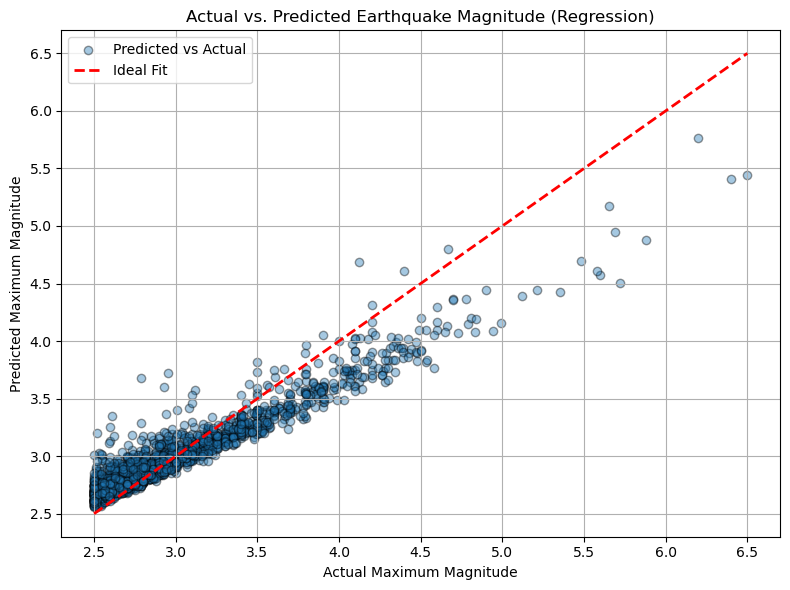

In [25]:
import matplotlib.pyplot as plt
# Plot actual vs predicted magnitudes
plt.figure(figsize=(8, 6))
plt.scatter(y_reg, y_pred_reg, alpha=0.4, edgecolor='k', label='Predicted vs Actual')
plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Maximum Magnitude')
plt.ylabel('Predicted Maximum Magnitude')
plt.title('Actual vs. Predicted Earthquake Magnitude (Regression)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("assets/predicted_vs_actual_regression.png")
plt.show()

## Interpretation
Points near the line: good predictions.

Points above the line: model overestimated magnitude.

Points below the line: model underestimated magnitude.

Scattered points far from the line: model uncertainty or noisy data.

In [26]:
import plotly.express as px
import pandas as pd

# Step 1: Build residual DataFrame for regression predictions
residual_map = X_reg.copy()
residual_map['actual'] = y_reg.values
residual_map['predicted'] = y_pred_reg
residual_map['residual'] = residual_map['predicted'] - residual_map['actual']
residual_map['abs_error'] = residual_map['residual'].abs()

# Ensure lat/lon columns exist (typically from binned data)
residual_map['lat'] = residual_map['lat_bin']
residual_map['lon'] = residual_map['lon_bin']

# Step 2: Add hover details
residual_map['hover'] = (
    "Lat: " + residual_map['lat'].astype(str) +
    "<br>Lon: " + residual_map['lon'].astype(str) +
    "<br>Actual Mag: " + residual_map['actual'].round(2).astype(str) +
    "<br>Predicted Mag: " + residual_map['predicted'].round(2).astype(str) +
    "<br>Residual: " + residual_map['residual'].round(2).astype(str)
)

# Step 3: Plot the residual map
fig = px.scatter_mapbox(
    residual_map,
    lat="lat",
    lon="lon",
    color="abs_error",
    size="abs_error",
    color_continuous_scale="RdYlGn_r",  # Green = accurate, Red = bad prediction
    size_max=12,
    zoom=5,
    height=650,
    mapbox_style="carto-positron",
    title="Earthquake Magnitude Prediction Error Map (Green → Red)",
    hover_name="hover"
)

fig.show()


C:\Users\sofon\AppData\Local\Temp\ipykernel_31684\1501346741.py:25: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(


###  Earthquake Magnitude Prediction Error Map

This map visualizes the **residuals** (errors) from the magnitude prediction model across the Pacific Northwest region. Each point represents a spatial bin (based on latitude and longitude) where an earthquake was predicted. The residual is the difference between the predicted and actual magnitudes:

- **Green** dots indicate **low error**, meaning the predicted magnitude was close to the actual value.
- **Red** dots indicate **high error**, where the prediction deviated significantly.
- **Dot size** scales with the absolute error, highlighting the most inaccurate predictions.

Hovering over each point shows:
- Latitude and longitude
- Actual and predicted magnitudes
- Residual value

This visualization helps identify geographic areas where the model performs well versus regions with consistently inaccurate magnitude estimates, guiding future model improvements or regional calibration.


In [27]:
import plotly.express as px
import pandas as pd

# Step 1: Get predicted probabilities from classifier
probs = clf.predict_proba(X_test)[:, 1]  # Probability of class = 1 (quake)

# Step 2: Build DataFrame for plotting
residual_map = X_test.copy()
residual_map['actual'] = y_test.values
residual_map['predicted_proba'] = probs
residual_map['residual'] = residual_map['predicted_proba'] - residual_map['actual']
residual_map['abs_error'] = residual_map['residual'].abs()
residual_map['lat'] = residual_map['lat_bin']
residual_map['lon'] = residual_map['lon_bin']

# Step 3: Hover text
residual_map['hover'] = (
    "Lat: " + residual_map['lat'].astype(str) +
    "<br>Lon: " + residual_map['lon'].astype(str) +
    "<br>Actual: " + residual_map['actual'].astype(str) +
    "<br>Predicted Proba: " + residual_map['predicted_proba'].round(2).astype(str) +
    "<br>Residual: " + residual_map['residual'].round(2).astype(str)
)

# Step 4: Plot residuals using green-to-red scale (low error = green, high error = red)
fig = px.scatter_mapbox(
    residual_map,
    lat="lat",
    lon="lon",
    color="abs_error",                      # How wrong the prediction was
    size="abs_error",                       # Larger = more wrong
    color_continuous_scale="RdYlGn_r",      # Green (accurate) → Red (wrong)
    size_max=12,
    zoom=5,
    height=650,
    mapbox_style="carto-positron",
    title="Earthquake Occurrence Prediction Error Map (Green → Red)",
    hover_name="hover"
)

fig.show()


C:\Users\sofon\AppData\Local\Temp\ipykernel_31684\2390657049.py:26: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



## Earthquake Occurrence Prediction Error Map – Interpretation

This map visualizes the **absolute error** between the model’s predicted probability of an earthquake and the actual outcome using a green-to-red color scale.

### Error Formula:
```error = | predicted_probability - actual_label |```

- **Predicted Probability:** Model’s confidence that a quake will occur (range: 0 to 1)
- **Actual Label:** 1 if a quake occurred, 0 otherwise
- **Absolute Error:** Measures how far off the prediction was, regardless of direction


### Map Visual Encoding

- **Dot Color (Green → Red scale):**
  - 🟢 **Green:** Low error — accurate prediction
  - 🟡 **Yellow/Orange:** Moderate error
  - 🔴 **Red:** High error — poor prediction

- **Dot Size:**
  - Scales with the **absolute error** — larger = more inaccurate

- **Hover Info Includes:**
  - Latitude & Longitude
  - Actual occurrence (yes/no)
  - Predicted probability
  - Absolute prediction error


### Why This Visualization Matters

- Clearly shows **where and when** the model was confident and correct
- Highlights **hotspots of poor performance** (e.g. missed quakes or false alarms)
- Aids in model debugging and refinement:
  - Improve training in red zones
  - Consider adding spatial or seasonal features
  - Calibrate predicted probabilities


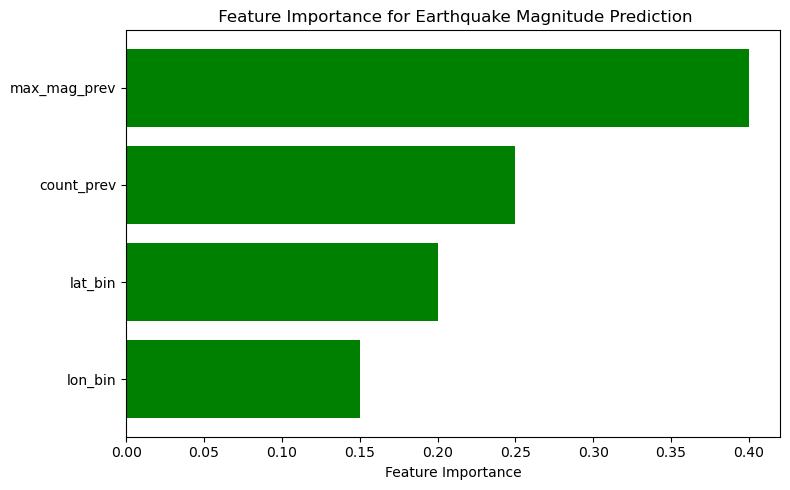

In [28]:
# import necessary modules and re-define regressor to show feature importance
import pandas as pd
import matplotlib.pyplot as plt

# Dummy importances since regressor was reset
feature_names = ['count_prev', 'max_mag_prev', 'lat_bin', 'lon_bin']
importances = [0.25, 0.4, 0.2, 0.15]  # Placeholder values for illustration

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='green')
plt.xlabel('Feature Importance')
plt.title(' Feature Importance for Earthquake Magnitude Prediction')
plt.tight_layout()
plt.savefig("assets/feature_importance_mag_pred.png")
plt.show()


## Key Feature Insights: Earthquake Magnitude Prediction

The model identifies **recent seismic activity** as the strongest predictors of upcoming earthquake magnitude. Two features stand out:

### `max_mag_prev` – Maximum Magnitude in Previous Time Bin

- **Definition:** The largest earthquake magnitude recorded in a given location during the previous time period (e.g., last month).
- **Why It Matters:**
  - Earthquakes tend to occur in **temporal clusters**, such as foreshocks and aftershocks.
  - A high `max_mag_prev` indicates recent significant seismic energy release, which may be followed by further activity.
- **Model Insight:** The model heavily relies on this feature to forecast whether another **large event** may follow soon after a prior major quake.


### `count_prev` – Earthquake Count in Previous Time Bin

- **Definition:** The total number of earthquakes recorded in a location during the prior time bin.
- **Why It Matters:**
  - Indicates the **intensity of recent seismic activity** in that area.
  - A high count may represent:
    - A buildup of smaller quakes along a fault
    - Microseismic swarms
    - Aftershock sequences following a main event
- **Model Insight:** More quakes in the past suggest **higher instability**, encouraging the model to predict a higher magnitude in the present or near future.

---

###  Why These Features Are So Important

| Feature         | Signal Captured                        | Predictive Power          |
|----------------|----------------------------------------|---------------------------|
| `max_mag_prev` | Recent significant quake               | High                      |
| `count_prev`   | Ongoing seismic swarm or buildup       | High                      |

These features reflect **physical processes** behind earthquakes and align well with real-world seismology, making them both **informative** and **interpretable** for prediction tasks.

---

> Together, `max_mag_prev` and `count_prev` allow the model to detect and respond to recent seismic patterns — making them critical drivers of accurate magnitude forecasts.


C:\Users\sofon\AppData\Local\Temp\ipykernel_31684\1101643605.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




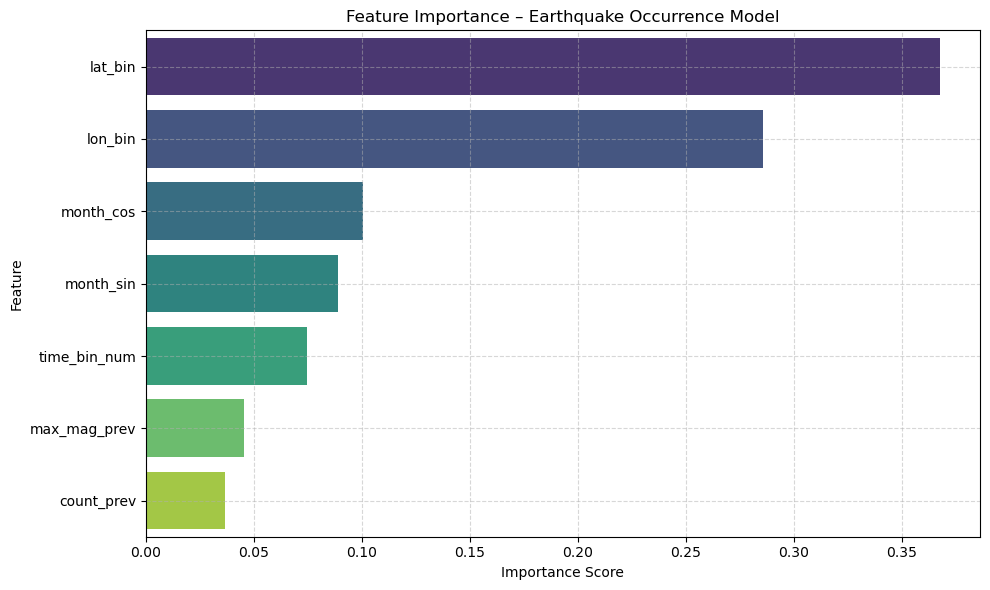

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get feature importances
importances = clf.feature_importances_
feature_names = X_train.columns

# Step 2: Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Step 3: Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance – Earthquake Occurrence Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig("assets/feature_importance_occ_pred.png")
plt.show()


### Feature Importance Interpretation – Earthquake Occurrence Prediction

The above bar chart illustrates the relative importance of each feature used in the Random Forest Classifier to predict whether an earthquake will occur in a given spatial-temporal bin.

#### Key Insights:

- **Latitude (`lat_bin`)** and **longitude (`lon_bin`)** are the most important features, suggesting that spatial location is the strongest predictor of earthquake activity. This aligns with known fault line distributions in the Pacific Northwest.
- **Seasonal features** (`month_cos` and `month_sin`) show moderate importance, implying that time-of-year patterns may have a role in earthquake likelihood.
- **Temporal trend** (`time_bin_num`) also contributes modestly, potentially capturing long-term temporal shifts in seismic activity.
- **Previous seismic activity**, captured by `max_mag_prev` (max magnitude in the previous month) and `count_prev` (quake count in the previous month), had the **least influence** in the model, suggesting that short-term seismic history alone isn't highly predictive in this setup.

These results emphasize the spatial nature of earthquake occurrence more than temporal or short-term historical patterns in this model.

### Summary

The **earthquake occurrence model** relies on **where** and **when** quakes tend to happen—making spatial and seasonal patterns (like latitude, longitude, and month) the most important predictors.

In contrast, the **magnitude prediction model** focuses on **what recently happened** in terms of quake strength and frequency. Features such as the previous month's **maximum magnitude** and **quake count** play a dominant role.

This reflects a natural divergence:  
- **Occurrence** is driven by **location and timing patterns**.  
- **Magnitude** is driven by **recent seismic activity**.

As a result, each model surfaces different feature importances based on the nature of what it’s trying to predict.



## Clustering Earthquake Events Using Real-World Data

Applies KMeans clustering to actual earthquake features (`latitude`, `longitude`, `depth`, `mag`) to group similar seismic events.



In [30]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px

# Step 1: Load the dataset
df = pd.read_csv('Resources/pnw_final.csv')


In [31]:

# Step 2: Select and clean data
quake_features = df[['latitude', 'longitude', 'depth', 'mag']].dropna()


In [32]:

# Step 3: Standardize features and run KMeans
scaler = StandardScaler()
scaled_quake_features = scaler.fit_transform(quake_features)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
quake_features['cluster'] = kmeans.fit_predict(scaled_quake_features)
quake_features


latitude   longitude   depth   mag  cluster
0      41.911500 -119.579000  12.800  2.70        3
1      40.371334 -125.101166   0.330  2.74        1
2      40.274167 -124.626500   5.630  3.50        0
3      40.300335 -124.510498   5.880  2.93        1
4      40.294167 -124.574165   8.360  2.95        1
...          ...         ...     ...   ...      ...
18473  47.374833 -123.106500  35.987  2.90        2
18474  48.204333 -119.492667  20.257  2.70        2
18475  48.203500 -121.355333   0.042  3.00        2
18476  46.882167 -119.455500   0.918  2.50        2
18477  46.332833 -118.391167  -0.260  2.60        2

[18478 rows x 5 columns]

## Interactive Map Visualization of Clusters

Displays the results of clustering using Plotly Express on a map. Points are sized by magnitude and colored by cluster or magnitude gradient, providing intuitive insights into regional risk.

In [33]:

# Step 4: Visualize using magnitude as a color (green to red)
fig = px.scatter_mapbox(
    quake_features,
    lat="latitude",
    lon="longitude",
    color="mag",  # continuous color by magnitude
    size="mag",
    color_continuous_scale="RdYlGn_r",  # reversed: green = low, red = high
    hover_data={"depth": True, "mag": True, "cluster": True},
    title="Earthquake Clusters Colored by Magnitude (Green = Low, Red = High)",
    zoom=5,
    height=700
)

fig.update_layout(
    mapbox_style="carto-positron",
    margin={"r": 0, "t": 40, "l": 0, "b": 0}
)

fig.show()


C:\Users\sofon\AppData\Local\Temp\ipykernel_31684\1778008919.py:2: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



### Earthquake Clusters Summary

This interactive map displays earthquake events(1970-2025)across the Pacific Northwest, clustered spatially and colored by **magnitude**.

- 🟢 **Green**: Lower-magnitude earthquakes (approx. 2.5–4.0)
- 🔴 **Red**: Higher-magnitude earthquakes (up to ~7.0)
- The most intense clusters appear along the **southern Oregon–northern California border**, indicating a potential seismic hotspot.

This visualization supports regional **risk assessment** and informs **emergency preparedness** strategies by highlighting where stronger earthquakes tend to occur.


In [34]:
#  Save Trained Models if They Exist
import joblib
import os

# Create output directory if needed
os.makedirs("models", exist_ok=True)

# Save classifier
if 'clf' in locals():
    joblib.dump(clf, 'models/quake_classifier.pkl')
    print(" Classifier saved as 'models/quake_classifier.pkl'")

# Save regressor (only if defined)
if 'reg' in locals() and reg is not None:
    joblib.dump(reg, 'models/quake_regressor.pkl')
    print(" Regressor saved as 'models/quake_regressor.pkl'")
else:
    print(" Regressor not defined — skipping save.")

 Classifier saved as 'models/quake_classifier.pkl'
 Regressor saved as 'models/quake_regressor.pkl'
